In [1]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.scipy as jsp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData

import zodiax as zx
import equinox as eqx

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
fname = "alfPic_PIONIER.fits"
ddir = "../data/"

data = oifits.open(ddir+fname)
oidata = OIData(data)

In [3]:
init_values = [-76.0532, -26.3609, 0.03]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))

In [4]:
from drpangloss.grid_fit import likelihood_grid
samples_dict = {
    "dra":  jnp.linspace(200., -200., 210), # left is more RA 
    "ddec": jnp.linspace(-200., 200., 220), # up is more dec
    "flux": 10.**jnp.linspace(-2, 0, 50)}

loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict) # calculate once to jit

In [5]:
%%time
loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict)

CPU times: user 9.51 s, sys: 37.5 ms, total: 9.55 s
Wall time: 1.55 s


In [6]:
loglike_im.max(axis=2).T.shape

(220, 210)

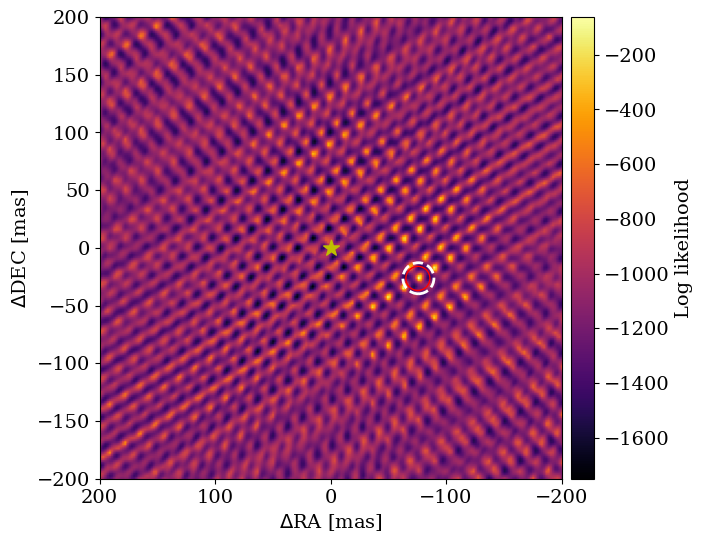

In [7]:
from drpangloss.plotting import plot_likelihood_grid
plot_likelihood_grid(loglike_im.max(axis=2), samples_dict, truths=init_values)
i, j, k = jnp.unravel_index(jnp.argmax(loglike_im, axis=None), loglike_im.shape)
plt.scatter(samples_dict["dra"][i], samples_dict["ddec"][j], edgecolor="r", marker="o", s=300, facecolors='none')

In [8]:
loglike_im[i,j,k]

Array(-61.15989969, dtype=float64)

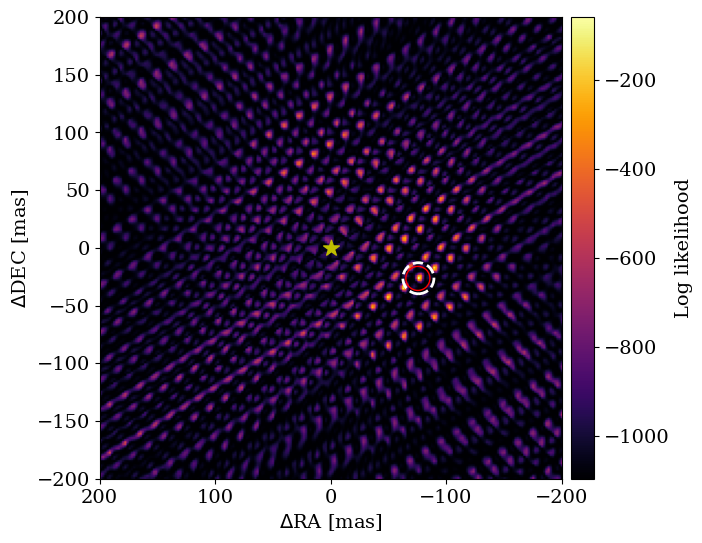

In [9]:
import matplotlib
from drpangloss.grid_fit import optimized_likelihood_grid
loglike_opt = optimized_likelihood_grid(oidata, BinaryModelCartesian, samples_dict)
plot_likelihood_grid(loglike_opt, samples_dict, truths=init_values)
i, j = jnp.unravel_index(jnp.argmax(loglike_opt, axis=None), loglike_opt.shape)
plt.scatter(samples_dict["dra"][i],samples_dict["ddec"][j], edgecolor="r", marker="o", s=300, facecolors='none')

In [10]:
i, j = jnp.unravel_index(jnp.argmax(loglike_opt, axis=None), loglike_opt.shape)
best_ra_opt, best_dec_opt = samples_dict["dra"][i], samples_dict["ddec"][j]

In [11]:
best_ra_opt, best_dec_opt

(Array(-75.59808612, dtype=float64), Array(-26.48401826, dtype=float64))

In [12]:
i, j, k = jnp.unravel_index(jnp.argmax(loglike_im, axis=None), loglike_im.shape)
best_ra, best_dec, best_flux = samples_dict["dra"][i], samples_dict["ddec"][j], samples_dict["flux"][k]

In [13]:
print(best_ra, best_dec, best_flux)

-75.5980861244019 -26.48401826484018 0.040949150623804255


(0.0, 1.1)

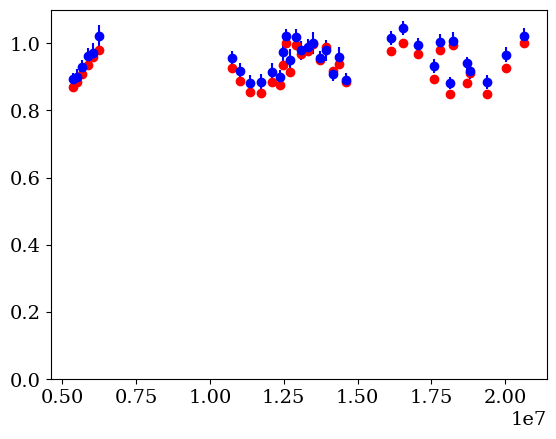

In [14]:
init_values = [best_ra, best_dec, best_flux]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))
data, errors = oidata.flatten_data()
x = jnp.concatenate(jnp.sqrt(oidata.u**2+oidata.v**2)[:,jnp.newaxis]/oidata.wavel, axis=0)
plt.errorbar(x, jnp.concatenate(data[0:6,:], axis=0), yerr=jnp.concatenate(errors[0:6,:], axis=0), fmt='bo', label="Data")
plt.plot(x, jnp.concatenate(model_data[0:6,], axis=0), 'ro', label="Model")
plt.ylim(0,1.1)

In [15]:
fit_values = [best_ra_opt,best_dec_opt,0.030]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, fit_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))
data, errors = oidata.flatten_data()

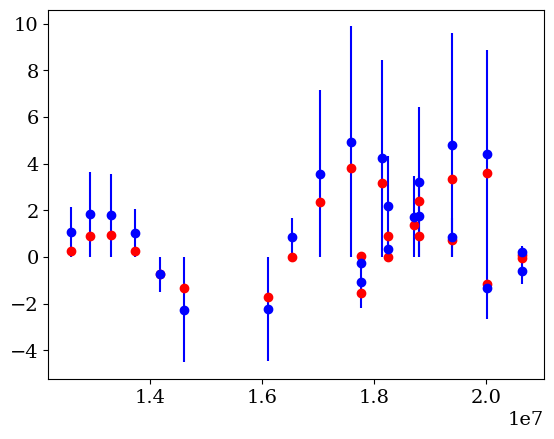

In [16]:
cp_x = jnp.concatenate(jnp.max(jnp.array([jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps1],
               jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps2],
               jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps3]]), axis=0)[:,jnp.newaxis] / oidata.wavel, axis=0)
data, errors = oidata.flatten_data()
cp_data = data[6:,:]
model_cp_data = model_data[6:,:]
plt.errorbar(cp_x, jnp.concatenate(cp_data, axis=0), yerr=jnp.concatenate(cp_data, axis=0), fmt='bo', label="Data")
plt.plot(cp_x, jnp.concatenate(model_cp_data, axis=0), 'ro', label="Model")

(0.0, 1.1)

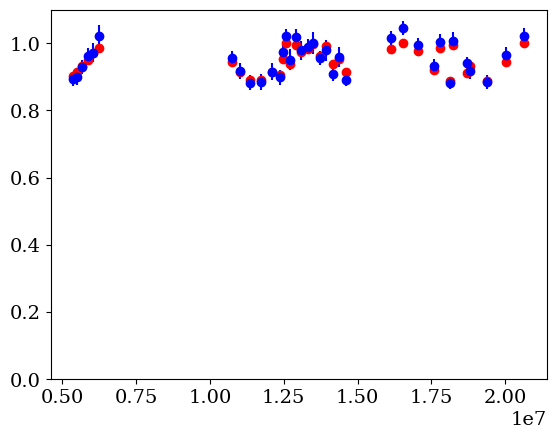

In [17]:

x = jnp.concatenate(jnp.sqrt(oidata.u**2+oidata.v**2)[:,jnp.newaxis]/oidata.wavel, axis=0)
plt.errorbar(x, jnp.concatenate(data[0:6,:], axis=0), yerr=jnp.concatenate(errors[0:6,:], axis=0), fmt='bo', label="Data")
plt.plot(x, jnp.concatenate(model_data[0:6,], axis=0), 'ro', label="Model")
plt.ylim(0,1.1)